## Computer Vision and OpenCV

In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

### Braille Image Processing

#### Loading Images


(242, 531, 3)


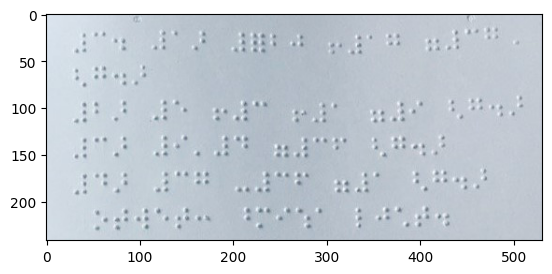

In [17]:
im = cv2.imread('data/braille.jpeg')
print(im.shape)
plt.imshow(im)

#### convert it to black and white

(242, 531)


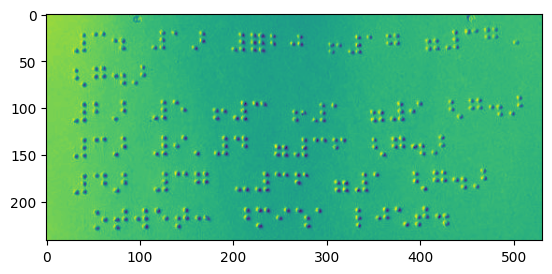

In [18]:
bw_im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
print(bw_im.shape)
plt.imshow(bw_im)

#### use thresholding to enhance the image a little bit

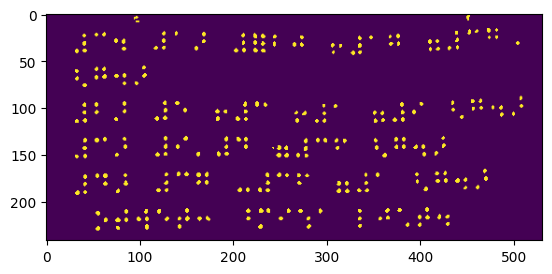

In [19]:
im = cv2.blur(bw_im,(3,3))
im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                           cv2.THRESH_BINARY_INV, 5, 4)
im = cv2.medianBlur(im, 3)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
im = cv2.GaussianBlur(im, (3,3), 0)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
plt.imshow(im)

#### using feature extraction to "extract" individual dots (i.e. convert the images to a set of coordinates of individual dots)

In [20]:
orb = cv2.ORB_create(5000)
f,d = orb.detectAndCompute(im,None)
print(f"First 5 points: { [f[i].pt for i in range(5)]}")

First 5 points: [(307.20001220703125, 40.80000305175781), (297.6000061035156, 114.00000762939453), (423.6000061035156, 133.20001220703125), (242.40000915527344, 144.0), (103.68000793457031, 57.60000228881836)]


#### plot all points to make sure we got things right

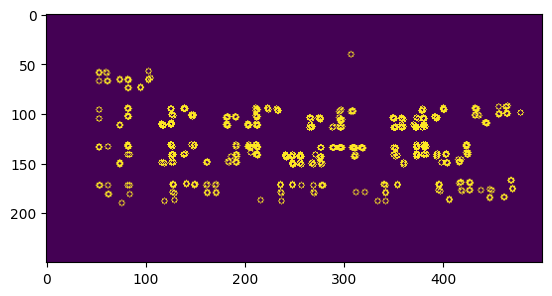

In [21]:
def plot_dots(dots):
    img = np.zeros((250,500))
    for x in dots:
        cv2.circle(img,(int(x[0]),int(x[1])),3,(255,0,0))
    plt.imshow(img)

pts = [x.pt for x in f]
plot_dots(pts)

#### compute min and max coordinates to know the bounding box of the whole text to separate individual characters

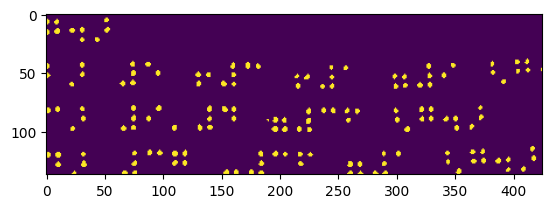

In [22]:
min_x, min_y, max_x, max_y = [int(f([z[i] for z in pts])) for f in (min,max) for i in (0,1)]
min_y+=13
plt.imshow(im[min_y:max_y,min_x:max_x])

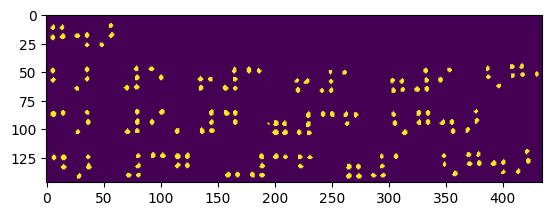

In [23]:
off = 5
src_pts = np.array([(min_x-off,min_y-off),(min_x-off,max_y+off),
                    (max_x+off,min_y-off),(max_x+off,max_y+off)])
w = int(max_x-min_x+off*2)
h = int(max_y-min_y+off*2)
dst_pts = np.array([(0,0),(0,h),(w,0),(w,h)])
ho,m = cv2.findHomography(src_pts,dst_pts)
trim = cv2.warpPerspective(im,ho,(w,h))
plt.imshow(trim)

#### slice the image into individual characters

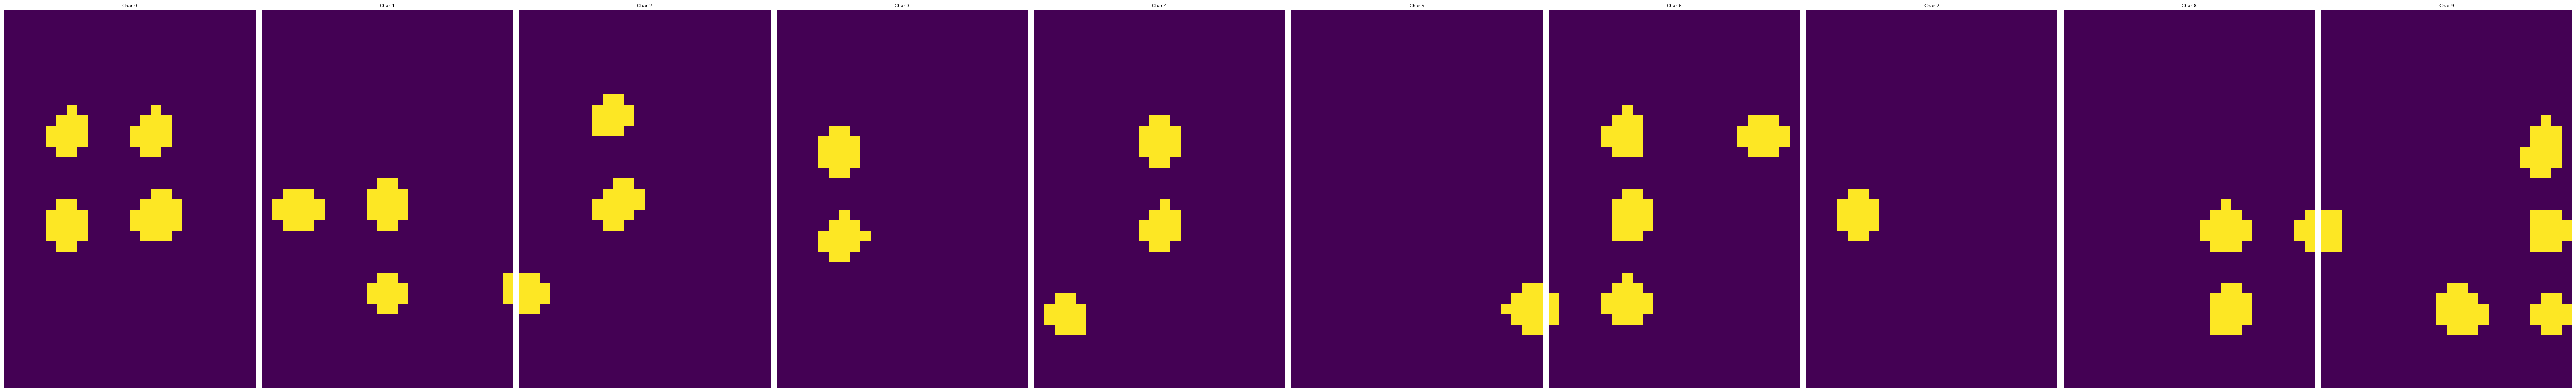

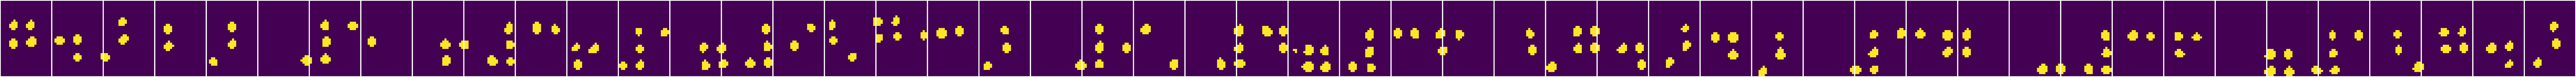

In [29]:
char_h = 36
char_w = 24
def slice(img):
    dy,dx = img.shape
    y = 0
    while y+char_h<dy:
        x=0
        while x+char_w<dx:
            # Skip empty lines
            if np.max(img[y:y+char_h,x:x+char_w])>0:
                yield img[y:y+char_h,x:x+char_w]
            x+=char_w
        y+=char_h

sliced = list(slice(trim))

# display the first 10 characters
display_images(sliced[:10],titles=[f"Char {i}" for i in range(10)],fontsize=8)

display_images(sliced)

### Motion Detection using Frame Difference


#### Load the video

Total frames: 876


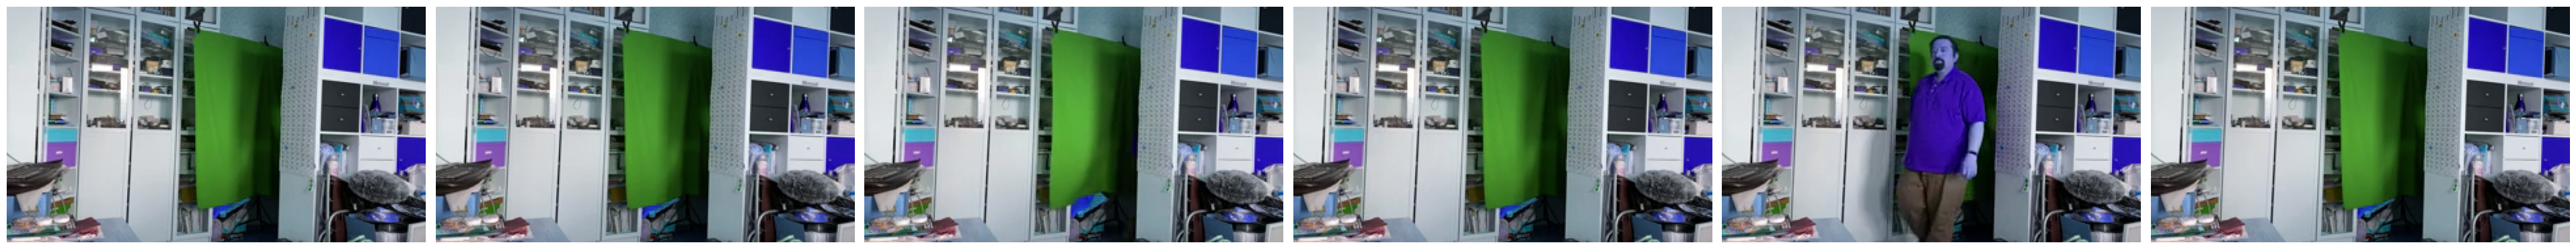

In [30]:
vid = cv2.VideoCapture('data/motionvideo.mp4')

c = 0
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)
    c+=1
vid.release()
print(f"Total frames: {c}")
display_images(frames[::150])

####  compute and plot the frame differences

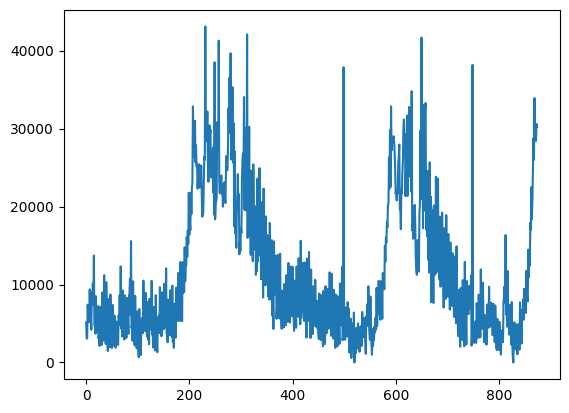

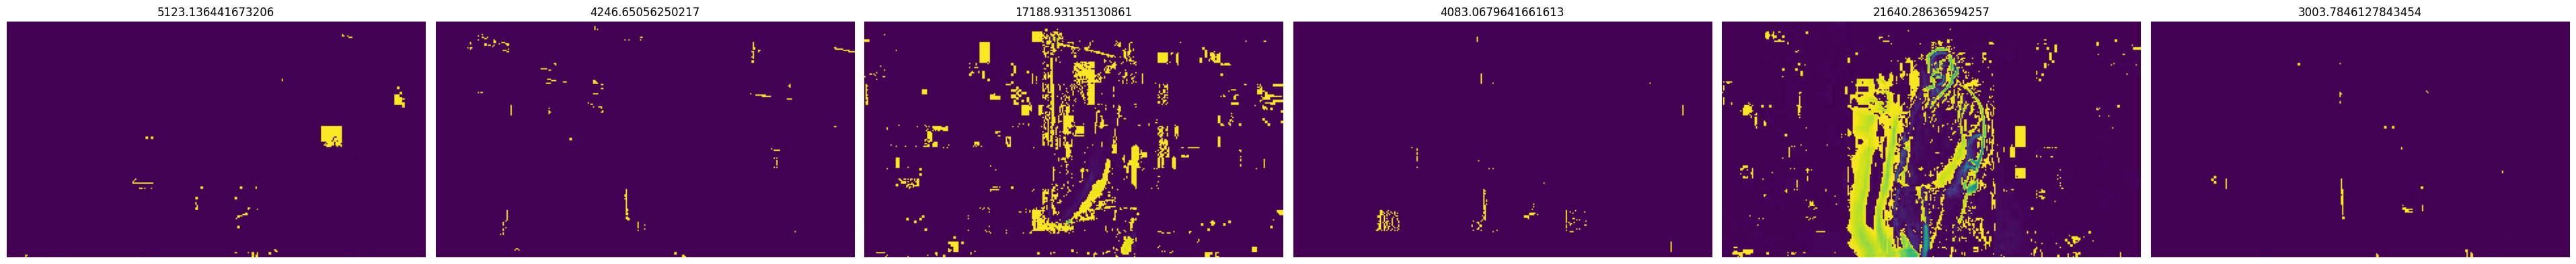

In [31]:
bwframes = [cv2.cvtColor(x,cv2.COLOR_BGR2GRAY) for x in frames]
diffs = [(p2-p1) for p1,p2 in zip(bwframes[:-1],bwframes[1:])]
diff_amps = np.array([np.linalg.norm(x) for x in diffs])
plt.plot(diff_amps)
display_images(diffs[::150],titles=diff_amps[::150])

#### remove the noise and smooth the curve

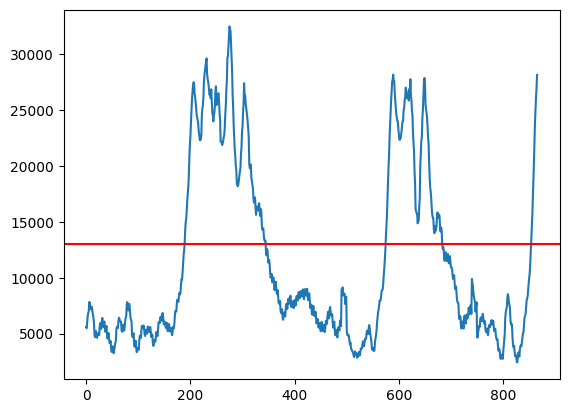

In [35]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

threshold = 13000

plt.plot(moving_average(diff_amps,10))
plt.axhline(y=threshold, color='r', linestyle='-')

#### find the frames where the difference exceeds the threshold

In [36]:
active_frames = np.where(diff_amps>threshold)[0]

def subsequence(seq,min_length=30):
    ss = []
    for i,x in enumerate(seq[:-1]):
        ss.append(x)
        if x+1 != seq[i+1]:
            if len(ss)>min_length:
                return ss
            ss.clear()

sub = subsequence(active_frames)
print(sub)

[np.int64(195), np.int64(196), np.int64(197), np.int64(198), np.int64(199), np.int64(200), np.int64(201), np.int64(202), np.int64(203), np.int64(204), np.int64(205), np.int64(206), np.int64(207), np.int64(208), np.int64(209), np.int64(210), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int64(215), np.int64(216), np.int64(217), np.int64(218), np.int64(219), np.int64(220), np.int64(221), np.int64(222), np.int64(223), np.int64(224), np.int64(225), np.int64(226), np.int64(227), np.int64(228), np.int64(229), np.int64(230), np.int64(231), np.int64(232), np.int64(233), np.int64(234), np.int64(235), np.int64(236), np.int64(237), np.int64(238), np.int64(239), np.int64(240), np.int64(241), np.int64(242), np.int64(243), np.int64(244), np.int64(245), np.int64(246), np.int64(247), np.int64(248), np.int64(249), np.int64(250), np.int64(251), np.int64(252), np.int64(253), np.int64(254), np.int64(255), np.int64(256), np.int64(257), np.int64(258), np.int64(259), np.int64(260), np.int64(

sub[0]: 195 sub[-1]: 322


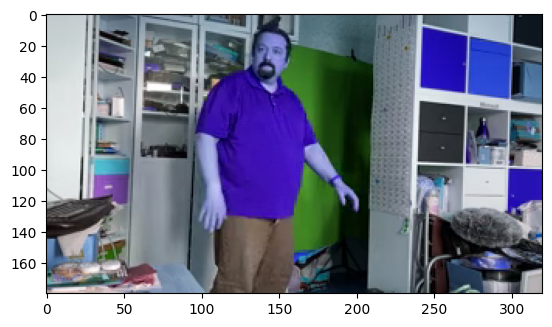

In [39]:
plt.imshow(frames[(sub[0]+sub[-1])//2])
print("sub[0]:",sub[0],"sub[-1]:",sub[-1])

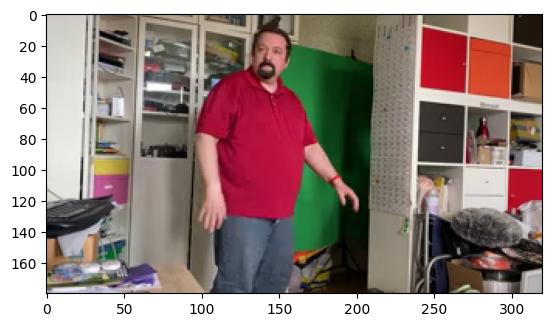

In [40]:
plt.imshow(cv2.cvtColor(frames[(sub[0]+sub[-1])//2],cv2.COLOR_BGR2RGB))


#### Extract Motion using Optical Flow


In [41]:
flows = [cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
         for f1,f2 in zip(bwframes[:-1],bwframes[1:])]
flows[0].shape

(180, 320, 2)

195 322


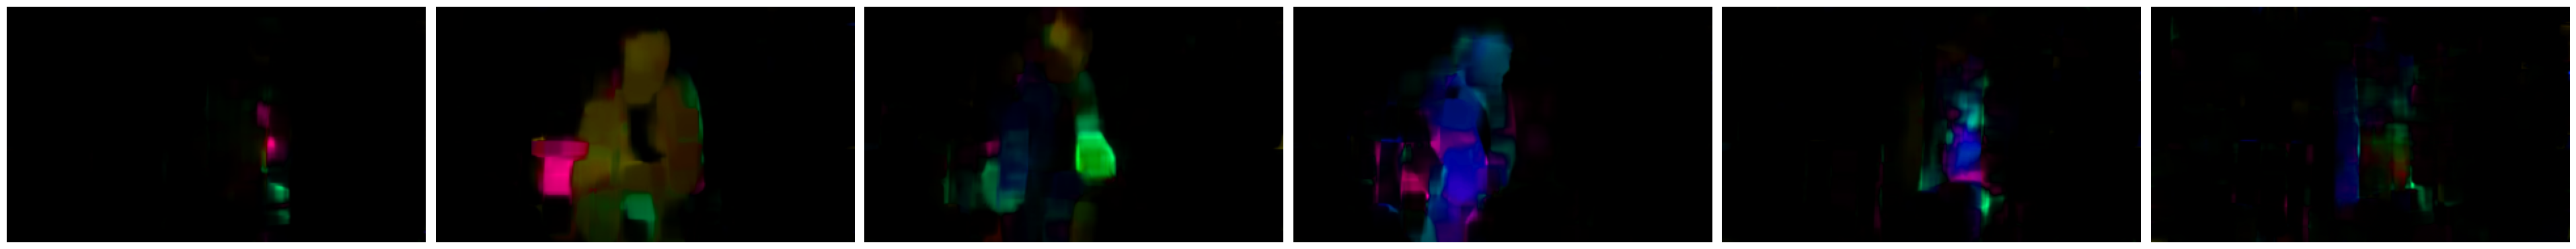

In [42]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)

start = sub[0]
stop = sub[-1]
print(start,stop)

frms = [flow_to_hsv(x) for x in flows[start:stop]]
display_images(frms[::25])